In [1]:
import glob
import pyorc
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
# np.random.seed(0)

# MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July']

# videos = []
# for month in MONTHS:
#     for video in sorted(glob.glob("*.mp4", root_dir=f"{month}/videos/")):
#         # videos.append(f"{month}/results/{video.split('.')[0]}_velocimetry_results.nc")
#         videos.append(f"{video.split('.')[0]}")

# videos = sorted(np.random.choice(np.array(videos), size=len(videos)//10, replace=False))

# with open('filter_explore.txt', "a") as f:
#     for video in videos:
#         f.write(f"{video}\n")

In [3]:
df_new = pd.read_csv('Mask/dataset1.csv')
df_new.datetime = pd.to_datetime(df_new.datetime)
df_new['ver'] = 'new'
# df_new

In [4]:
df_orig = pd.read_csv('Mask/dataset_og.csv')
df_orig.datetime = pd.to_datetime(df_orig.datetime)
df_orig['ver'] = 'orig'
df_orig = df_orig[df_orig.datetime.isin(df_new.datetime.unique())]
# df_orig

In [5]:
df = pd.concat([df_new, df_orig]).reset_index()[[
    'datetime', 'x', 'y', 'v_x', 'v_y', 'v_len', 's2n', 'corr',
    'sun_altitude', 'sun_azimuth', 'spacial_location', 'LRO_discharge',
    'LRO_discharge_site', 'turbidity', 'vegetation', 'visibility',
    'cloudcover', 'solarradiation', 'uvindex', 'conditions', 'v_pos', 'ver'
]]
# print(df.columns)
# df

No masks:
	mean: 0.2703467002227633
	variance: 0.04141071492999632
	n: 872741
Default masks:
	mean: 0.6427625360550214
	variance: 0.07797498698793018
	n: 443677


<Axes: xlabel='v_len', ylabel='Count'>

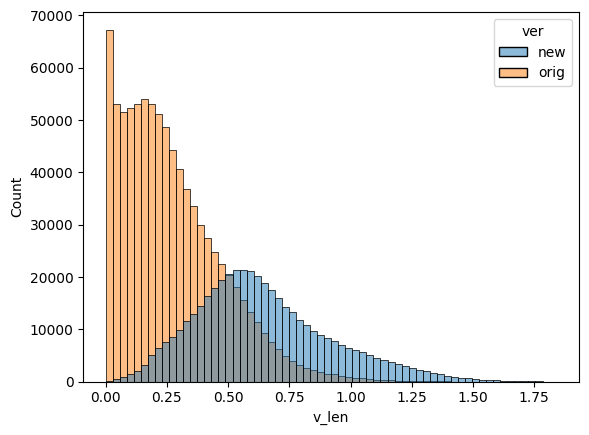

In [6]:
print("No masks:")
print(f"\tmean: {np.mean(df[df.ver == 'orig'].v_len)}")
print(f"\tvariance: {np.var(df[df.ver == 'orig'].v_len)}")
print(f"\tn: {len(df[(df.ver == 'orig') & ~df.v_len.isna()])}")

print("Default masks:")
print(f"\tmean: {np.mean(df[df.ver == 'new'].v_len)}")
print(f"\tvariance: {np.var(df[df.ver == 'new'].v_len)}")
print(f"\tn: {len(df[(df.ver == 'new') & ~df.v_len.isna()])}")

sns.histplot(
    data=df,
    x='v_len',
    hue='ver',
    bins=64
)

In [7]:
ds = xr.open_dataset('nc_old/video_capture_2024-07-01_12-22-37_velocimetry_results.nc')

july1 =  ds.mean(dim="time", keep_attrs=True).to_dataframe().reset_index()
july1['v_len'] = np.sqrt(july1.v_x**2 + july1.v_y**2)

ds.velocimetry.mask.corr(inplace=True)
ds.velocimetry.mask.minmax(inplace=True)
ds.velocimetry.mask.rolling(inplace=True)
ds.velocimetry.mask.outliers(inplace=True)
ds.velocimetry.mask.variance(inplace=True)
ds.velocimetry.mask.angle(angle_tolerance=0.5*np.pi)
ds.velocimetry.mask.count(inplace=True)
ds.velocimetry.mask.window_mean(wdw=2, inplace=True, tolerance=0.5, reduce_time=True)

ds = ds.mean(dim="time", keep_attrs=True)

july1_mask = ds.to_dataframe().reset_index()
july1_mask['v_len'] = np.sqrt(july1_mask.v_x**2 + july1_mask.v_y**2)

/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
radar = pd.read_csv('radar/test1.csv')

radar mean: 1.6
No masks:
	mean: 0.3149873477865589
	variance: 0.03414707028613786
	n: 11189
Default masks:
	mean: 0.7206297995871869
	variance: 0.058298697165957016
	n: 6911


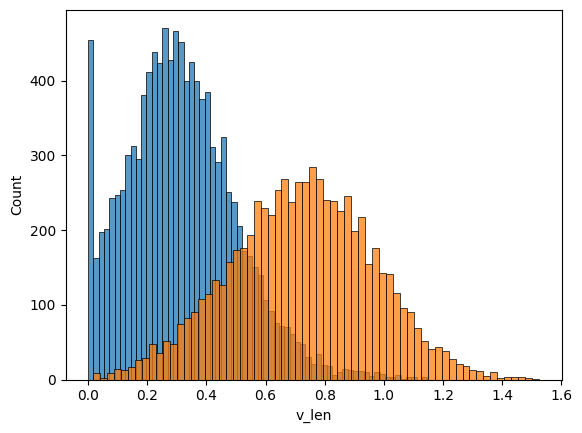

In [9]:
print(f"radar mean: {np.median(radar[' Average velocity value'])}")

print("No masks:")
print(f"\tmean: {np.mean(july1.v_len)}")
print(f"\tvariance: {np.var(july1.v_len)}")
print(f"\tn: {len(july1[~july1.v_len.isna()])}")

print("Default masks:")
print(f"\tmean: {np.mean(july1_mask.v_len)}")
print(f"\tvariance: {np.var(july1_mask.v_len)}")
print(f"\tn: {len(july1_mask[~july1_mask.v_len.isna()])}")

sns.histplot(
    data=july1,
    x='v_len',
    # hue='ver',
    bins=64
)
sns.histplot(
    data=july1_mask,
    x='v_len',
    # hue='ver',
    bins=64
)
plt.show()

In [10]:
# means, vars = [], []
# means_mask, vars_mask = [], []

# for timestamp in sorted(df.datetime.unique()):
#     print(timestamp)

#     print("No masks:")
#     mean = np.mean(df[(df.datetime == timestamp) & (df.ver == 'orig')].v_len)
#     means.append(mean)
#     print(f"\tmean: {mean}")
#     var = np.var(df[(df.datetime == timestamp) & (df.ver == 'orig')].v_len)
#     vars.append(var)
#     print(f"\tvariance: {var}")

#     print("Default masks:")
#     mean = np.mean(df[(df.datetime == timestamp) & (df.ver == 'new')].v_len)
#     means_mask.append(mean)
#     print(f"\tmean: {mean}")
#     var = np.var(df[(df.datetime == timestamp) & (df.ver == 'new')].v_len)
#     vars_mask.append(var)
#     print(f"\tvariance: {var}")
    
#     sns.histplot(
#         data=df[df.datetime == timestamp],
#         x='v_len',
#         hue='ver',
#         bins=64
#     )
#     plt.show()
#     plt.clf()

#     print()

In [11]:
# sns.histplot(
#     data=means,
#     binrange=[0, 1.6],
#     bins=16
# )
# sns.histplot(
#     data=means_mask,
#     binrange=[0, 1.6],
#     bins=16
# )
# plt.show()
# plt.clf()

# sns.histplot(
#     data=vars,
#     binrange=[0, 0.4],
#     bins=16
# )
# sns.histplot(
#     data=vars_mask,
#     binrange=[0, 0.4],
#     bins=16
# )
# plt.show()
# plt.clf()
